![](https://avatars3.githubusercontent.com/u/27442526?v=4)

[Ibis](https://www.ibis-project.org/) is a mature open-source project that has been in development for about 5 years; it currently has about 1350 stars on Github. It provides an interface to SQL for Python programmers and bridges the gap between remote storage & execution systems. These features provide authors the ability to:

1. write backend-independent [SQL](https://en.wikipedia.org/wiki/SQL) expressions in [Python](https://en.wikipedia.org/wiki/Python_(programming_language));
1. access different database connections (eg. [SQLite](https://www.sqlite.org/index.html), [OmniSci](https://www.omnisci.com/), [Pandas](http://pandas.pydata.org/)); and
1. confirm visually their SQL queries with [directed acyclic graphs (DAGs)](https://en.wikipedia.org/wiki/Directed_acyclic_graph).

<!-- TEASER_END -->

Ibis is an alternative approach using databases that relies on Python rather than SQL experience. Typically, users have to learn an entirely new syntax or flavor of SQL to perform simple tasks. Now, those familiar with Python can avoid a new learning curve by using Ibis for composing and executing database queries using familiar Python syntaxes (i.e., similar to Pandas and Dask). Ibis assists in formation of SQL expressions by providing visual feedback about each Python object.
This post focuses on writing SQL expressions in Python and how to compose queries visually using Ibis. We'll demonstrate this with a SQLite database&mdash;in particular, [Sean Lahman’s baseball database](http://www.seanlahman.com/baseball-archive/statistics/).

## Connecting to a database

To get started, we’ll need to establish a [database connection](https://en.wikipedia.org/wiki/Database_connection). Ibis makes it easy to create connections of different types. Let's go ahead and do this now with the function [`ibis.sqlite.connect`](https://docs.ibis-project.org/docs/api.html#sqlite-client) (in this instance, the database used is a SQLite database):

In [1]:
%matplotlib inline
import ibis
import pathlib, requests

db_path = pathlib.Path.cwd() / 'lahmansbaseballdb.sqlite'

if not db_path.exists():          # Downloads database if necessary
    with open(db_path, 'wb') as f:
        URL = 'https://github.com/WebucatorTraining/lahman-baseball-mysql/raw/master/lahmansbaseballdb.sqlite'
        req = requests.get(URL)
        f.write(req.content)

client = ibis.sqlite.connect(db_path.name) # Opens SQLite database connection

The `client` object represents our connection to the database. It is essential to use the appropriate Ibis connection&mdash;SQLite in this case constructed through the [`ibis.sqlite` namespace](https://docs.ibis-project.org/docs/api.html#sqlite-client)&mdash;for the particular database. 

This [baseball database](http://www.seanlahman.com/baseball-archive/statistics/) has 29 distinct tables; we can see by running the following code:

In [2]:
tables = client.list_tables()
print(f'This database has {len(tables)} tables.')

This database has 29 tables.


## Selecting and visualizing tables

Displaying the list `tables`, gives the names of all the tables which include, among others, tables with identifiers
```{python}
[...'appearances'...'halloffame', 'homegames', 'leagues', 'managers',...]
```
Let's use the database connection to extract & examine dataframe representations of the `halloffame` and `appearances` tables from the baseball database. To do this, we can invoke the [`table` method](https://docs.ibis-project.org/docs/generated/ibis.impala.api.ImpalaDatabase.table.html) associated with the `client` object called with the appropriate names.

In [3]:
halloffame = client.table('halloffame', database='base')
appearances = client.table('appearances', database='base')

At the moment, the objects objects `halloffame` and `appearances` just constructed don’t hold any data; instead, the objects are *expressions* of type `TableExpr` that represent putative operations applied to the data. The data itself is inert wherever it's actually located&mdash;in this case, within the SQLite database. We can verify this by examining their types or by using assertions like this:

In [4]:
print(f'The object appearances has type {type(appearances).__name__}.')
assert isinstance(halloffame, ibis.expr.types.TableExpr), 'Wrong type for halloffame'

The object appearances has type TableExpr.


We can examine the contents of these Ibis table expressions using the [`TableExpr.limit`](https://docs.ibis-project.org/docs/generated/ibis.expr.api.TableExpr.limit.html) or the `TableExpr.head` method (similar to the [Pandas `DataFrame.head` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html)). That is, we can define an object `sample` that represents a sub-table comprising the first few rows of the `halloffame` table:

In [5]:
sample = halloffame.head()
print(f'The object sample is of type {type(sample).__name__}')

The object sample is of type TableExpr


Remember, the object `sample` is a `TableExpr` object representing some SQL query to extracts a sub-table from a larger table. We can view the actual SQL query corresponding to `sample` by compiling it with the [`compile` method](https://docs.ibis-project.org/docs/generated/ibis.expr.api.Expr.compile.html) and converting the result to a string:

In [6]:
str(sample.compile())

'SELECT t0."ID", t0."playerID", t0.yearid, t0."votedBy", t0.ballots, t0.needed, t0.votes, t0.inducted, t0.category, t0.needed_note \nFROM base.halloffame AS t0\n LIMIT ? OFFSET ?'

Another useful feature of Ibis is its ability to represent an SQL query as a [DAG (Directed Acyclic Graph)](https://en.wikipedia.org/wiki/Directed_acyclic_graph). For instance, evaluating the object `sample` at the interactive command prompt yields a visualization of a sequence of database operations:

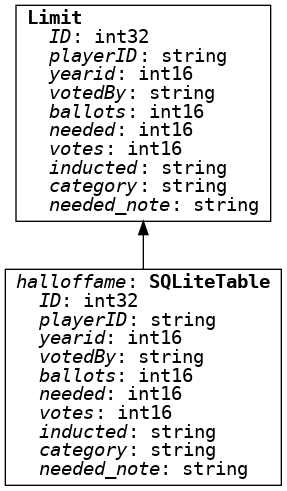

In [7]:
sample  # This produces the image below in a suitably enabled shell

This image of a DAG is produced using [Graphviz](https://graphviz.org/); those familiar with [Dask](https://dask.org/) may have used a similar helpful feature to assemble [task graphs](https://docs.dask.org/en/latest/graphviz.html).

Finally, the actual sub-table corresponding to the expression sample can be extracted using the [`execute` method](https://docs.ibis-project.org/docs/generated/ibis.expr.api.Expr.execute.html) (similar to [`compute`](https://docs.dask.org/en/latest/api.html#dask.compute) in [Dask](https://docs.dask.org)). The result returned by executing the expression sample is a [tidy](https://vita.had.co.nz/papers/tidy-data.pdf) [Pandas `DataFrame`](https://pandas.pydata.org/docs/reference/frame.html) object.

In [8]:
result = sample.execute()
print(f'The type of result is {type(result).__name__}')
result    # Leading 5 rows of halloffame table)

The type of result is DataFrame


ID   playerID  yearid votedBy  ballots  needed  votes inducted category  \
0   1   cobbty01    1936   BBWAA      226     170    222        Y   Player   
1   2   ruthba01    1936   BBWAA      226     170    215        Y   Player   
2   3  wagneho01    1936   BBWAA      226     170    215        Y   Player   
3   4  mathech01    1936   BBWAA      226     170    205        Y   Player   
4   5  johnswa01    1936   BBWAA      226     170    189        Y   Player   

  needed_note  
0        None  
1        None  
2        None  
3        None  
4        None

A similar extraction of the leading five rows from the `appearances` table (in one line)
gives the following table with 23 columns:

In [9]:
appearances.head().execute()  # Leading 5 rows of appearances table)

ID  yearID teamID  team_ID lgID   playerID  G_all  GS  G_batting  \
0   1    1871    TRO        8   NA  abercda01      1   1          1   
1   2    1871    RC1        7   NA   addybo01     25  25         25   
2   3    1871    CL1        3   NA  allisar01     29  29         29   
3   4    1871    WS3        9   NA  allisdo01     27  27         27   
4   5    1871    RC1        7   NA  ansonca01     25  25         25   

   G_defense  ...  G_2b  G_3b  G_ss  G_lf  G_cf  G_rf  G_of  G_dh  G_ph  G_pr  
0          1  ...     0     0     1     0     0     0     0     0     0     0  
1         25  ...    22     0     3     0     0     0     0     0     0     0  
2         29  ...     2     0     0     0    29     0    29     0     0     0  
3         27  ...     0     0     0     0     0     0     0     0     0     0  
4         25  ...     2    20     0     1     0     0     1     0     0     0  

[5 rows x 23 columns]

## Filtering and selecting data

As mentioned earlier, Ibis uses familiar Pandas syntax to build SQL queries. As an example, let's look at the various kinds of entries in the `category` column from the `halloffame` table. A nice way to do this is to extract the relevant column with attribute access and apply the [`value_counts` method](https://docs.ibis-project.org/docs/generated/ibis.expr.api.ColumnExpr.value_counts.html). Remember, an invokation of `execute` is needed to realize the actual expression.

In [10]:
halloffame.category.value_counts().execute()

category  count
0            Manager     74
1  Pioneer/Executive     41
2             Player   4066
3             Umpire     10

There are four different types of entries in this column, most of which are `Player`s. To illustrate filtering and selection, we'll create a expression `condition` of boolean values corresponding to rows from the `halloffame` table in which the `category` column has the value `Player`. The boolean values represented by `condition` can be extracted from the table `halloffame` using brackets. The final result is bound to the identifier `players`.

In [11]:
condition = halloffame.category == 'Player'
players = halloffame[condition]

In [12]:
players.execute() # take a look at this table

ID   playerID  yearid   votedBy  ballots  needed  votes inducted  \
0        1   cobbty01    1936     BBWAA    226.0   170.0  222.0        Y   
1        2   ruthba01    1936     BBWAA    226.0   170.0  215.0        Y   
2        3  wagneho01    1936     BBWAA    226.0   170.0  215.0        Y   
3        4  mathech01    1936     BBWAA    226.0   170.0  205.0        Y   
4        5  johnswa01    1936     BBWAA    226.0   170.0  189.0        Y   
...    ...        ...     ...       ...      ...     ...    ...      ...   
4061  4187  lidgebr01    2018     BBWAA    422.0   317.0    0.0        N   
4062  4188  millwke01    2018     BBWAA    422.0   317.0    0.0        N   
4063  4189  zambrca01    2018     BBWAA    422.0   317.0    0.0        N   
4064  4190  morrija02    2018  Veterans      NaN     NaN    NaN        Y   
4065  4191  trammal01    2018  Veterans      NaN     NaN    NaN        Y   

     category needed_note  
0      Player        None  
1      Player        None  
2      Player        None  
3      Player        None  
4      Player        None  
...       ...         ...  
4061   Player        None  
4062   Player        None  
4063   Player        None  
4064   Player        None  
4065   Player        None  

[4066 rows x 10 columns]

## Joining Ibis tables

If we want a single view of the `halloffame` players and their appearances, we need to [join](https://en.wikipedia.org/wiki/Join_(SQL)) the tables `halloffame` and `appearances`. To do this, we’ll perform an [inner join](https://stackoverflow.com/questions/38549/what-is-the-difference-between-inner-join-and-outer-join) based on the `playerID` columns of our `players` & `appearances` tables.

In [13]:
condition = players.playerID == appearances.playerID

We notice that both the `players` and the `appearances` tables each have a column labelled `ID`. This column needs to be excluded from `appearances`; otherwise the overlapping columns will corrupt the computed join. Specifically, we want to filter out the `ID` and `playerID` columns from the `appearances` table. One strategy to do this is to use a list comprehension.

In [14]:
columns = [col for col in appearances.columns if col not in ('playerID', 'ID')]

Now, we use the [`TableExpr.join` method](https://docs.ibis-project.org/docs/generated/ibis.expr.api.TableExpr.join.html#ibis.expr.api.TableExpr.join) to compute an inner join of the `players` table and the filtered `appearances` table; the result is bound to the identifier `unmaterialized`.

In [15]:
unmaterialized = players.join(appearances[columns], condition)

## Materializing the join

We used the identifier `unmaterialized` just above to emphasize that the resulting expression is *not* a [materialized view](https://en.wikipedia.org/wiki/Materialized_view) (that would be required to build new expressions). Without a materialized view, Ibis raises an exception (as demonstrated here).

In [16]:
try:
    unmaterialized.distinct()
except Exception as e:
    print('Unable to execute "unmaterialized.distinct()"')
    print(repr(e))

Unable to execute "unmaterialized.distinct()"
IbisError('Table operation is not yet materialized')


The [`distinct` method](https://docs.ibis-project.org/docs/generated/ibis.expr.api.TableExpr.distinct.html#ibis.expr.api.TableExpr.distinct) in the preceding code behaves like the [Pandas `DataFrame.drop_duplicates` method](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.drop_duplicates.html), i.e., it drops duplicated rows. We can obtain such a materialized view to circumvent the exception above using the expression's `materialize` method.

In [17]:
join = unmaterialized.materialize().distinct()

The code above completes the join and binds the resulting expression to the materialized object `join`; here is a sample of the leading five rows of our joined data (notice the result has 31 columns).

In [18]:
join.head().execute()

ID   playerID  yearid votedBy  ballots  needed  votes inducted category  \
0  2861  aaronha01    1982   BBWAA      415     312    406        Y   Player   
1  3744  abbotji01    2005   BBWAA      516     387     13        N   Player   
2   147  adamsba01    1937   BBWAA      201     151      8        N   Player   
3   260  adamsba01    1938   BBWAA      262     197     11        N   Player   
4   385  adamsba01    1939   BBWAA      274     206     11        N   Player   

  needed_note  ...  G_2b G_3b  G_ss G_lf  G_cf  G_rf  G_of  G_dh  G_ph  G_pr  
0        None  ...    16    0    15    0     0     0     0     0     0     0  
1        None  ...    16    0    15    0     0     0     0     0     0     0  
2        None  ...    16    0    15    0     0     0     0     0     0     0  
3        None  ...    16    0    15    0     0     0     0     0     0     0  
4        None  ...    16    0    15    0     0     0     0     0     0     0  

[5 rows x 31 columns]

Ibis supports other join strategies as methods of the class `TableExpr`. The following list comprehension shows us what they are.

In [19]:
[method_name for method_name in dir(players) if 'join' in method_name]

['anti_join',
 'any_inner_join',
 'any_left_join',
 'asof_join',
 'cross_join',
 'inner_join',
 'join',
 'left_join',
 'outer_join',
 'semi_join']

## Executing an expression

We'll now expand the expression `join` as a Pandas DataFrame object. We'll use this DataFrame to answer the following question:

<center>
How many pitchers have been inducted into the hall of fame?
</center>

Some of the "hitters" have also been "pitchers", so we’ll need to filter out rows corresponding to those appearances from the table `join`. That is, to identify a specific player as a "pitcher", we’ll choose those players who played *mostly* as pitchers; in particular, we’ll take 100 games as an arbitrary threshold between pitchers and non-pitchers. The column `G_p` from the table `join` represents the numbers of games a player played as a pitcher; the desired filtering expression, then, is as follows:

In [20]:
pitchers = join[join.G_p > 100]

Next, we group the `pitchers` table based on a specific pair of columns (stored as a list `cols`) and then count them annually using a `groupby` with a `count` aggregation.

In [21]:
cols = [pitchers.inducted, pitchers.yearID]
grouped_pitchers = pitchers.groupby(cols).count()

The expression `grouped_pitchers` is still an Ibis `TableExpr`; as we've seen several times now, it can be realized as a Pandas DataFrame using the `execute` method. The resulting DataFrame's index can be set as a multi-index using the `inducted` and `yearID` columns.

In [22]:
df = grouped_pitchers.execute().set_index('inducted yearID'.split())
df

count
inducted yearID       
N        1936      105
         1937      106
         1938      114
         1939       99
         1942       67
...                ...
Y        2014        3
         2015        4
         2016        2
         2017        3
         2018        6

[150 rows x 1 columns]

The dataframe `df` has counts of the number of pitchers who were (`inducted` index `'Y'`) and were not (`inducted` index `'N'`) inducted into the baseball Hall of Fame in a given year. We'll pull in all the relevant counts of inductees into a dataframe `count_inducted_pitchers`. Notice the use of the Pandas `DataFrame.fillna` method to assign 0s in rows appropriately (i.e., reflecting that no pitchers were inducted into the Hall of Fame in those years).

In [23]:
count_inducted_pitchers = df.loc['Y'].fillna(0).rename({'count':'Inducted pitchers'})
count_inducted_pitchers

count
yearID       
1936        5
1937        3
1938        1
1939        7
1942        1
...       ...
2014        3
2015        4
2016        2
2017        3
2018        6

[76 rows x 1 columns]

The Pandas `DataFrame` & `Series` classes have a convenient plotting interface. We'll use a dictionary `options` to specify keyword arguments to tidy the final invokation of [`plot.bar`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.bar.html).

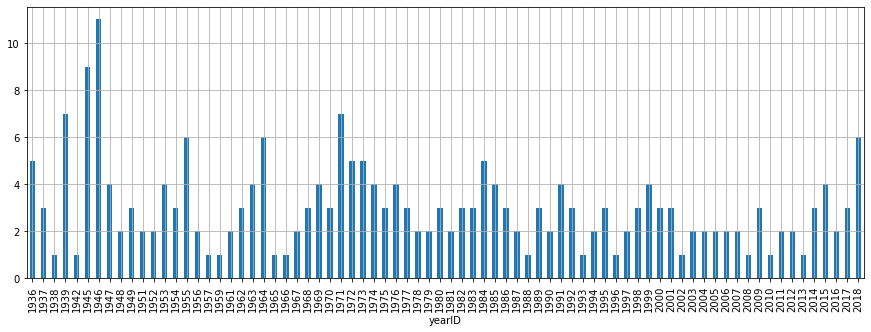

In [24]:
options = dict(figsize=(15, 5), grid=True, legend=None)
count_inducted_pitchers.plot.bar(**options);

## What next?

That's it! In future posts, we’ll explore other backends and visualize more Ibis objects. If you’d like to contribute to Ibis, please take a look at
[Ibis contributing guide](https://docs.ibis-project.org/contributing.html) and [OpenTeams](https://openteams.com/).